# PCA-PSD analysis of the CLYC data

Preliminary analysis looked OK, but the first PCA dimension was clearly something like the energy.
Let's have a go at improving this...

In [1]:
import tables, json
import numpy as np
from scipy.signal import medfilt, wiener

from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, \
    AgglomerativeClustering, DBSCAN, Birch, estimate_bandwidth

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
%matplotlib inline

In [179]:
datafile = "/home/lbignell/NeutronSpec/Beamtime_CLYC_May2017/run1494652579.h5"
h5file = tables.open_file(datafile, 'r')
CLYCwfms = h5file.root.wfms[:, 0, :]
h5file.close()

I did some analysis at the ipython console, and applied the median + wiener filter that I've been using, then normalised the waveforms to charge and did some PCA + clustering analysis. I discovered the following:

- The PCA doesn't work very well! There isn't a clear clustering effect. My suspicion is that when I normalise to charge, the signals with very low S/N (the small pulses) just get their noise amplified and this confuses the PCA algorithm.
- I can probably try to eliminate this problem by setting a pulse charge cut. Here's the spectrum for the file I'm analysing (I'll cut everything with > 3000 charge): 

<img src="files/ChargeSpec_low.png">

- The clustering algorithms also don't work very well, but I'll reserve judgement on those until I get the PCA right.

In [180]:
goodwfm = np.empty(len(CLYCwfms), dtype=bool)
Qt_test = np.empty(len(CLYCwfms), dtype=np.float32)
for i, wfm in enumerate(CLYCwfms):
    wfm = medfilt(wfm, kernel_size=7)
    wfm = wiener(wfm)
    BG = np.mean(wfm[1:20])
    Qt = sum(wfm[30:]) - len(wfm[30:])*BG
    Qt_test[i] = Qt
    if Qt > -2000:
        #noise
        goodwfm[i] = False
    else:
        goodwfm[i] = True
    CLYCwfms[i] = (wfm-BG)/Qt

print("Fraction of waveforms passing the cut: {0}".format(sum(goodwfm)/len(goodwfm)))

/home/lbignell/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/lbignell/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Fraction of waveforms passing the cut: 0.5522298739694704


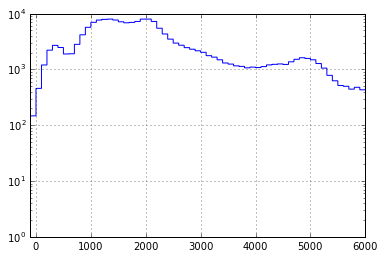

In [184]:
fig = plt.figure()
plt.hist(-Qt_test, bins=1000, range=(-1000,99000), histtype='step');
plt.yscale('log')
plt.xlim(-100,6000)
plt.grid()

(0, 200)

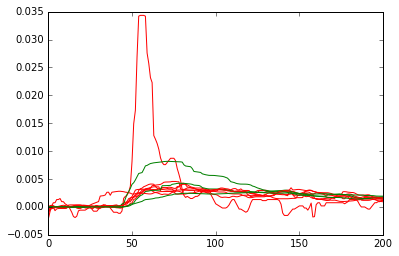

In [185]:
fig = plt.figure()
#plot the first 10 waveforms.
for i in range(10):
    if goodwfm[i]:
        plt.plot(CLYCwfms[i], 'g')
    else:
        plt.plot(CLYCwfms[i], 'r')
plt.xlim(0,200)

Now lets do PCA!
First exclude the low amplitude pulses entirely.
Later I can fit on the good data and transform the entire dataset.

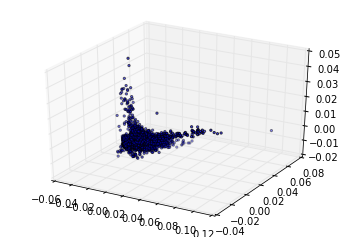

In [186]:
thepca = PCA(n_components=10)
thepca.fit(CLYCwfms[goodwfm])
X_t = thepca.transform(CLYCwfms[goodwfm])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_t[:,0], X_t[:,1], X_t[:,2], marker='.')

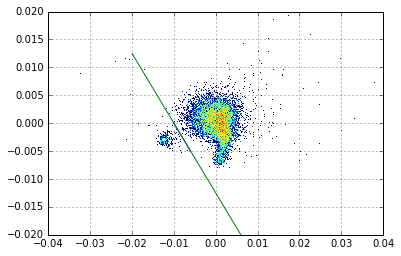

In [204]:
fig = plt.figure()
plt.hist2d(X_t[:,0], X_t[:,1], bins=(1000,1000), range=((-0.04,0.04),(-0.02, 0.02)), norm=LogNorm());
plt.grid()
#plt.ylim(-0.01,0.01)
#plt.xlim(-0.02,0.015)
plt.plot((-0.01,-0.006),(0,-0.005));
slope, intercept = np.polyfit((-0.01,-0.006),(0,-0.005), 1)
xvals = np.linspace(-0.02,0.015)
plt.plot(xvals, slope*xvals + intercept)
bottomcut = X_t[:,1] < (X_t[:,0]*slope + intercept)
#bottomcut = (X_t[:,1] < -0.005)&(X_t[:,0]>0)

Yay! At least 2 groups, maybe 3...

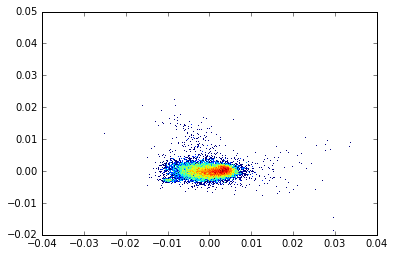

In [158]:
fig = plt.figure()
plt.hist2d(X_t[:,0], X_t[:,2], bins=(1000,1000), range=((-0.04,0.04),(-0.02, 0.05)), norm=LogNorm());
#plt.ylim(-0.01,0.01);
#plt.xlim(-0.015,0.01);
#plt.grid();

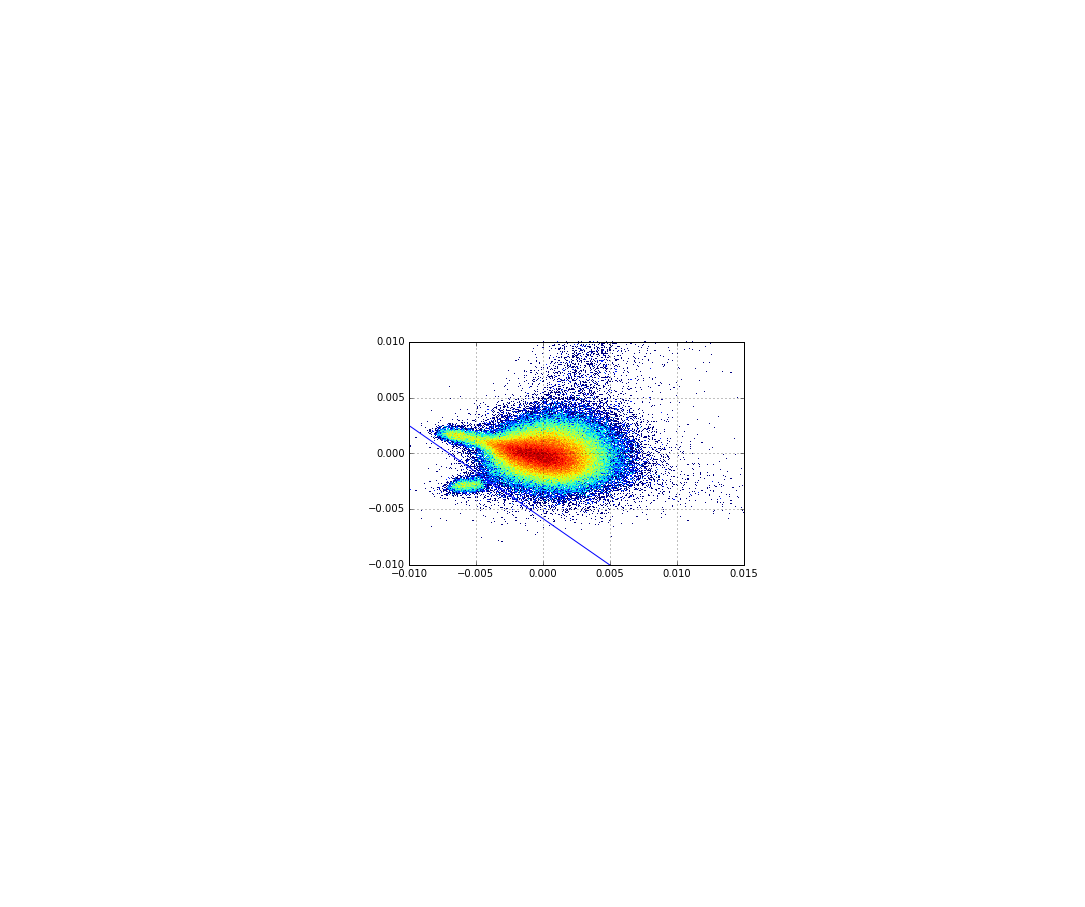

In [165]:
fig = plt.figure()
plt.hist2d(X_t[:,1], X_t[:,2], bins=(1000,1000), range=((-0.04,0.04),(-0.04, 0.04)), norm=LogNorm());
plt.ylim(-0.01,0.01);
plt.xlim(-0.01,0.015);
plt.grid()
slope, intercept = np.polyfit((-0.007,0.005),(0,-0.01), 1)
xvals = np.linspace(-0.02,0.005)
plt.plot(xvals, slope*xvals + intercept)
bottomcut = X_t[:,2] < (X_t[:,1]*slope + intercept)

In [134]:
thepca.explained_variance_ratio_

array([ 0.20056913,  0.08749597,  0.03808145,  0.03161608,  0.02576609,
        0.02388291,  0.02025299,  0.01851161,  0.01681521,  0.01641566])

To give us some idea of what we're doing; do some conventional analysis:

In [135]:
Qf = np.empty(len(CLYCwfms[goodwfm]), dtype=np.float64)
Qt = np.empty(len(CLYCwfms[goodwfm]), dtype=np.float64)
for i, wfm in enumerate(CLYCwfms[goodwfm]):
    Qf[i] = sum(wfm[40:150])
    Qt[i] = sum(wfm[40:])


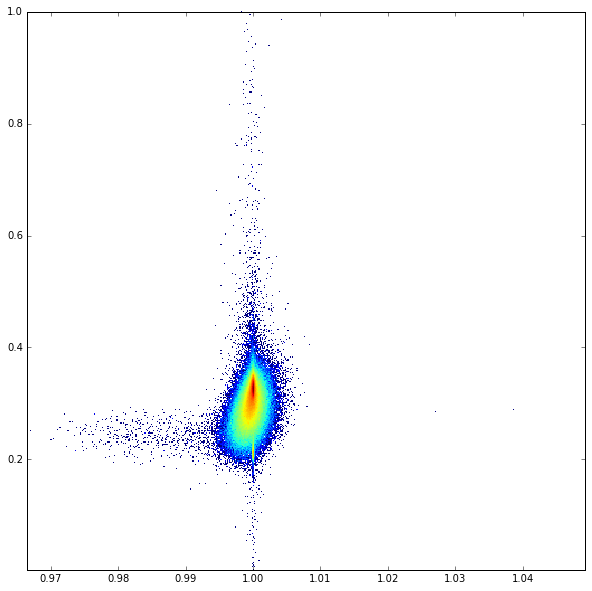

In [144]:
fig = plt.figure(figsize=(10,10))
plt.hist2d(Qt[(Qf/Qt)<=1], (Qf/Qt)[(Qf/Qt)<=1], bins=(500,500), norm=LogNorm());

Fraction of neutrons = 0.08420387957163063
PSD FOM: 1.6075521642273196 +/- 0.002002693120478873


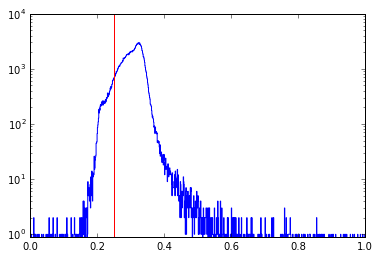

In [145]:
fig = plt.figure()
plt.hist((Qf/Qt)[(Qf/Qt)<=1], bins=1000, histtype='step');
plt.yscale('log')
plt.ylim(0.9,10000)
#plt.xlim(0.2,0.3)
neutcut=0.25
plt.plot([neutcut,neutcut], [0.1, 10000], 'r')
print("Fraction of neutrons = {0}".format(len((Qf/Qt)[(Qf/Qt)<=neutcut])/len((Qf/Qt)[(Qf/Qt)<=1])))
#Calculate estimate of PSD-FOM
mean_n = np.mean((Qf/Qt)[(Qf/Qt)<=neutcut])
std_n = np.std((Qf/Qt)[(Qf/Qt)<=neutcut])
umean_n = std_n/np.sqrt(len((Qf/Qt)[(Qf/Qt)>neutcut]))
ustd_n = std_n/np.sqrt(2*len((Qf/Qt)[(Qf/Qt)>neutcut])-2)
mean_g = np.mean((Qf/Qt)[(Qf/Qt)>neutcut])
std_g = np.std((Qf/Qt)[(Qf/Qt)>neutcut])
umean_g = std_g/np.sqrt(len((Qf/Qt)[(Qf/Qt)>neutcut]))
ustd_g = std_g/np.sqrt(2*len((Qf/Qt)[(Qf/Qt)>neutcut])-2)
thefom = np.abs(mean_n-mean_g)/(std_n+std_g)
theufom = np.sqrt(((mean_n/(std_n+std_g))*umean_g)**2 +
                  ((mean_g/(std_n+std_g))*umean_n)**2 +
                  ((thefom/(std_n+std_g))*ustd_g)**2 + 
                  ((thefom/(std_n+std_g))*ustd_n)**2)
print("PSD FOM: {0} +/- {1}".format(thefom,theufom))

Fraction of neutrons: 0.04324668486978242
PSD FOM: 3.407549697258407 +/- 0.006233493893018495


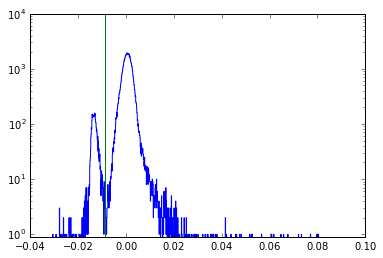

In [15]:
fig = plt.figure()
plt.hist(X_t[:,0], bins=1000, histtype='step')
plt.yscale('log')
plt.ylim(0.9,10000)
#plt.xlim(-0.01,-0.007)
pca_neutcut=-0.009
plt.plot([pca_neutcut, pca_neutcut], [0.1, 10000])
pcaneuts = X_t[:,0]<pca_neutcut
print("Fraction of neutrons: {0}".format(len(X_t[pcaneuts,0])/len(X_t[:,0])))
#Calculate estimate of PSD-FOM
mean_n = np.mean(X_t[pcaneuts, 0])
std_n = np.std(X_t[pcaneuts, 0])
umean_n = std_n/np.sqrt(len(X_t[~pcaneuts, 0]))
ustd_n = std_n/np.sqrt(2*len(X_t[~pcaneuts, 0])-2)
mean_g = np.mean(X_t[~pcaneuts, 0])
std_g = np.std(X_t[~pcaneuts, 0])
umean_g = std_g/np.sqrt(len(X_t[~pcaneuts, 0]))
ustd_g = std_g/np.sqrt(2*len(X_t[~pcaneuts, 0])-2)
thefom = np.abs(mean_n-mean_g)/(std_n+std_g)
theufom = np.sqrt(((mean_n/(std_n+std_g))*umean_g)**2 +
                  ((mean_g/(std_n+std_g))*umean_n)**2 +
                  ((thefom/(std_n+std_g))*ustd_g)**2 + 
                  ((thefom/(std_n+std_g))*ustd_n)**2)
print("PSD FOM: {0} +/- {1}".format(thefom,theufom))

Fraction of neutrons: 0.00016983146249150842
PSD FOM: 4.55101166697745 +/- 0.0065932966137900164


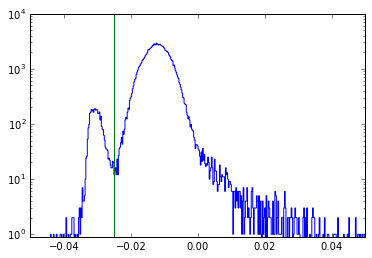

In [197]:
fig = plt.figure()
histmetric = X_t[:,1] - slope*X_t[:,0] + intercept
#histmetric = X_t[:,2] - slope*X_t[:,1] + intercept
plt.hist(histmetric, bins=1000, histtype='step')
plt.yscale('log')
plt.ylim(0.9,10000)
plt.xlim(-0.05,0.05)
pca_neutcut=-0.025
plt.plot([pca_neutcut, pca_neutcut], [0.1, 10000])
pcaneuts = X_t[:,0]<pca_neutcut
print("Fraction of neutrons: {0}".format(len(X_t[pcaneuts,0])/len(X_t[:,0])))
#Calculate estimate of PSD-FOM
mean_n = np.mean(X_t[pcaneuts, 0])
std_n = np.std(X_t[pcaneuts, 0])
umean_n = std_n/np.sqrt(len(X_t[~pcaneuts, 0]))
ustd_n = std_n/np.sqrt(2*len(X_t[~pcaneuts, 0])-2)
mean_g = np.mean(X_t[~pcaneuts, 0])
std_g = np.std(X_t[~pcaneuts, 0])
umean_g = std_g/np.sqrt(len(X_t[~pcaneuts, 0]))
ustd_g = std_g/np.sqrt(2*len(X_t[~pcaneuts, 0])-2)
thefom = np.abs(mean_n-mean_g)/(std_n+std_g)
theufom = np.sqrt(((mean_n/(std_n+std_g))*umean_g)**2 +
                  ((mean_g/(std_n+std_g))*umean_n)**2 +
                  ((thefom/(std_n+std_g))*ustd_g)**2 + 
                  ((thefom/(std_n+std_g))*ustd_n)**2)
print("PSD FOM: {0} +/- {1}".format(thefom,theufom))

In [469]:
3.41/2.77

1.2310469314079422

Great! just the first PCA dimension does a better job of discriminating neutrons and gammas. :-)

What else can we learn from the other dimensions? Let's try a clustering algorithm on just the first 2 dimensions initially -- looking at the plots, it actually appears that the 3rd PCA dimension has something to add as well, so I can try that later.

(-0.02, 0.02)

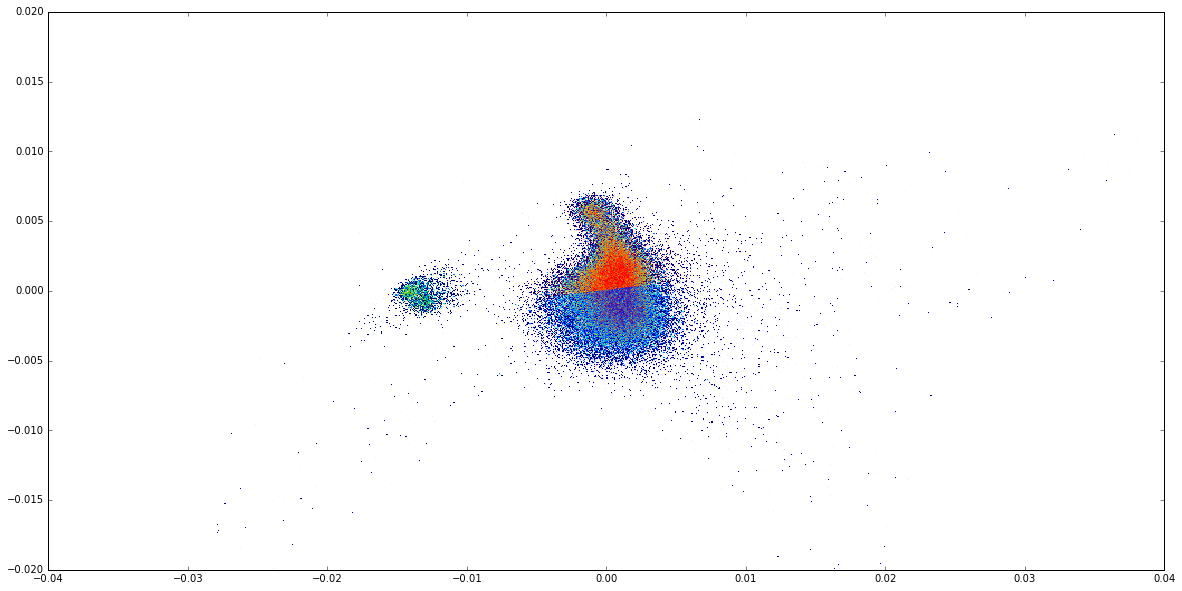

In [94]:
#Let's try K-means first...
clust_KM = KMeans(n_clusters=3, n_jobs=-2)
clust_KM.fit(X_t[:,0:2]) #First 2 PCA dimensions.
fig = plt.figure(figsize=(20,10))
plt.hist2d(X_t[:,0], X_t[:,1], bins=(1000,1000), range=((-0.04,0.04),(-0.02, 0.02)), norm=LogNorm());
plt.plot(X_t[clust_KM.labels_==0,0], X_t[clust_KM.labels_==0,1], 'r.', markersize=0.2, alpha=0.5)
plt.plot(X_t[clust_KM.labels_==1,0], X_t[clust_KM.labels_==1,1], 'g.', markersize=0.2, alpha=0.5)
plt.plot(X_t[clust_KM.labels_==2,0], X_t[clust_KM.labels_==2,1], 'b.', markersize=0.2, alpha=0.5)
plt.xlim(-0.04, 0.04)
plt.ylim(-0.02, 0.02)

(-0.02, 0.02)

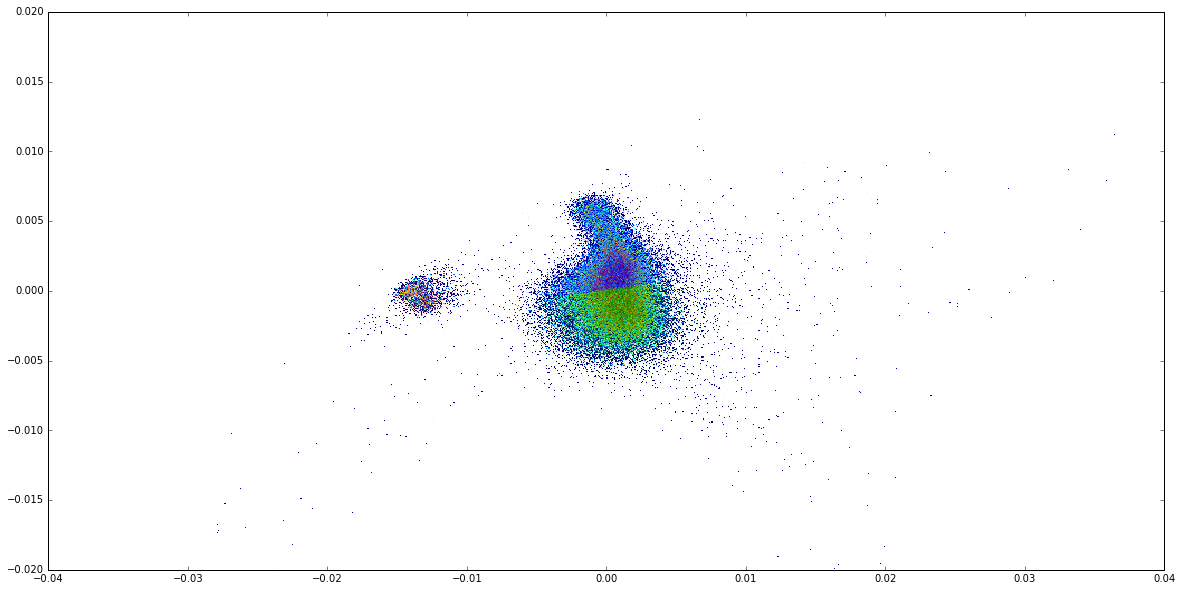

In [95]:
#Lets do the same for the first 3 PCA dimensions instead.
clust_KM3 = KMeans(n_clusters=3, n_jobs=-2)
clust_KM3.fit(X_t[:,0:3]) #First 3 PCA dimensions.
fig = plt.figure(figsize=(20,10))
plt.hist2d(X_t[:,0], X_t[:,1], bins=(1000,1000), range=((-0.04,0.04),(-0.02, 0.02)), norm=LogNorm());
plt.plot(X_t[clust_KM3.labels_==0,0], X_t[clust_KM3.labels_==0,1], 'r.', markersize=0.2, alpha=0.5)
plt.plot(X_t[clust_KM3.labels_==1,0], X_t[clust_KM3.labels_==1,1], 'g.', markersize=0.2, alpha=0.5)
plt.plot(X_t[clust_KM3.labels_==2,0], X_t[clust_KM3.labels_==2,1], 'b.', markersize=0.2, alpha=0.5)
plt.xlim(-0.04, 0.04)
plt.ylim(-0.02, 0.02)

In [81]:
print("Relative agreement between 2 PCA dims and 3 PCA dims classifiers: {0:.2f}%".format(
    100*sum(clust_KM.labels_==clust_KM3.labels_)/len(clust_KM.labels_)))

Relative agreement between 2 PCA dims and 3 PCA dims classifiers: 99.40%


OK, so adding the 3rd dimension doesn't really do much for K-means. What about mean-shift (which is meant to pick out 'blobs' of density in a continuum.

(-0.02, 0.02)

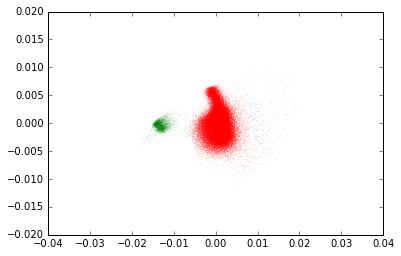

In [83]:
BW1 = estimate_bandwidth(X_t[:,0:2], n_jobs=-2)
clust_MS = MeanShift(bandwidth=BW1, n_jobs=-2)
clust_MS.fit(X_t[:, 0:2])
fig = plt.figure()
plt.plot(X_t[clust_MS.labels_==0,0], X_t[clust_MS.labels_==0,1], 'r.', markersize=0.1)
plt.plot(X_t[clust_MS.labels_==1,0], X_t[clust_MS.labels_==1,1], 'g.', markersize=0.1)
plt.plot(X_t[clust_MS.labels_==2,0], X_t[clust_MS.labels_==2,1], 'b.', markersize=0.1)
plt.xlim(-0.04, 0.04)
plt.ylim(-0.02, 0.02)

Well, that's nice, but it only picked up two of the blobs!

Group 0: 77288 member(s)
Group 1: 3526 member(s)
Group 2: 347 member(s)
Group 3: 80 member(s)
Group 4: 29 member(s)
Group 5: 28 member(s)
Group 6: 11 member(s)
Group 7: 9 member(s)
Group 8: 7 member(s)
Group 9: 15 member(s)
Group 10: 7 member(s)
Group 11: 10 member(s)
Group 12: 4 member(s)
Group 13: 91 member(s)
Group 14: 8 member(s)
Group 15: 3 member(s)
Group 16: 4 member(s)
Group 17: 2 member(s)
Group 18: 2 member(s)
Group 19: 2 member(s)
Group 20: 3 member(s)
Group 21: 2 member(s)
Group 22: 31 member(s)
Group 23: 1 member(s)
Group 24: 2 member(s)
Group 25: 1 member(s)
Group 26: 1 member(s)
Group 27: 1 member(s)
Group 28: 143 member(s)
Group 29: 1 member(s)
Group 30: 1 member(s)
Group 31: 1 member(s)
Group 32: 1 member(s)
Group 33: 1 member(s)
Group 34: 1 member(s)
Group 35: 1 member(s)
Group 36: 1 member(s)
Group 37: 1 member(s)
Group 38: 1 member(s)
Group 39: 1 member(s)
Group 40: 1 member(s)
Group 41: 1 member(s)


(-0.02, 0.02)

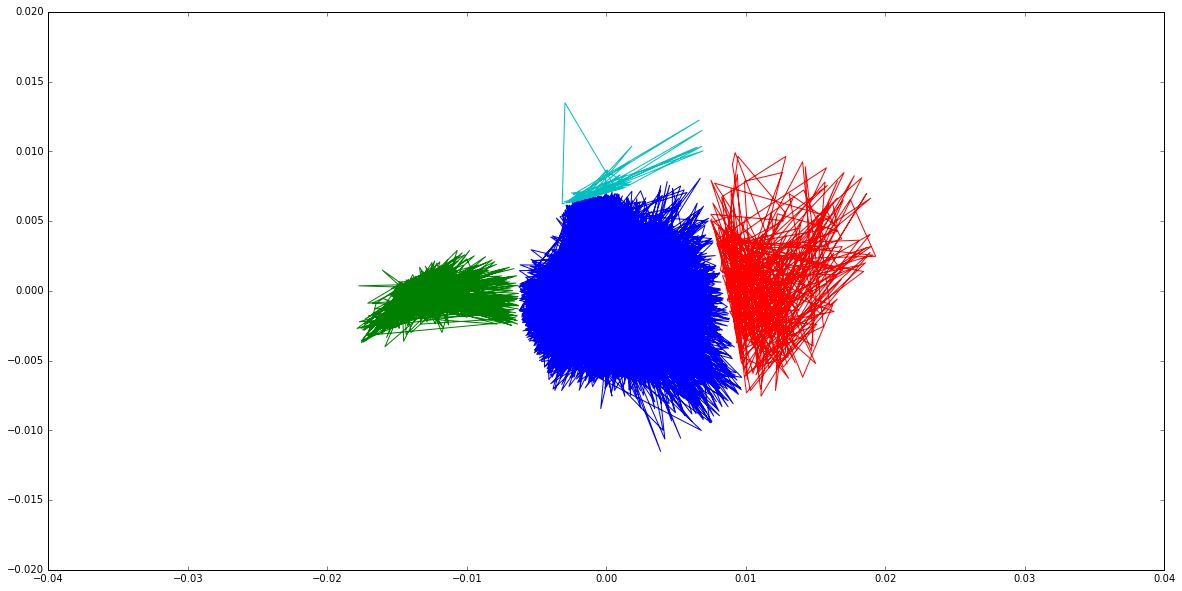

In [89]:
groups = np.unique(clust_MS.labels_)
fig = plt.figure(figsize=(20,10))
for i in groups:
    print("Group {0}: {1} member(s)".format(i, sum(clust_MS.labels_==i)))
    if sum(clust_MS.labels_==i) > 100:
        plt.plot(X_t[clust_MS.labels_==i,0], X_t[clust_MS.labels_==i,1], markersize=0.2)

plt.xlim(-0.04, 0.04)
plt.ylim(-0.02, 0.02)
    

Hmm, this seems less-than-useful...

How about I try a different clustering algorithm?

In [97]:
clust_Spec = SpectralClustering(n_clusters=3, eigen_solver='arpack', n_jobs=-2)
clust_Spec.fit(X_t[0:20000,0:2])

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=3, n_init=10, n_jobs=-2,
          n_neighbors=10, random_state=None)

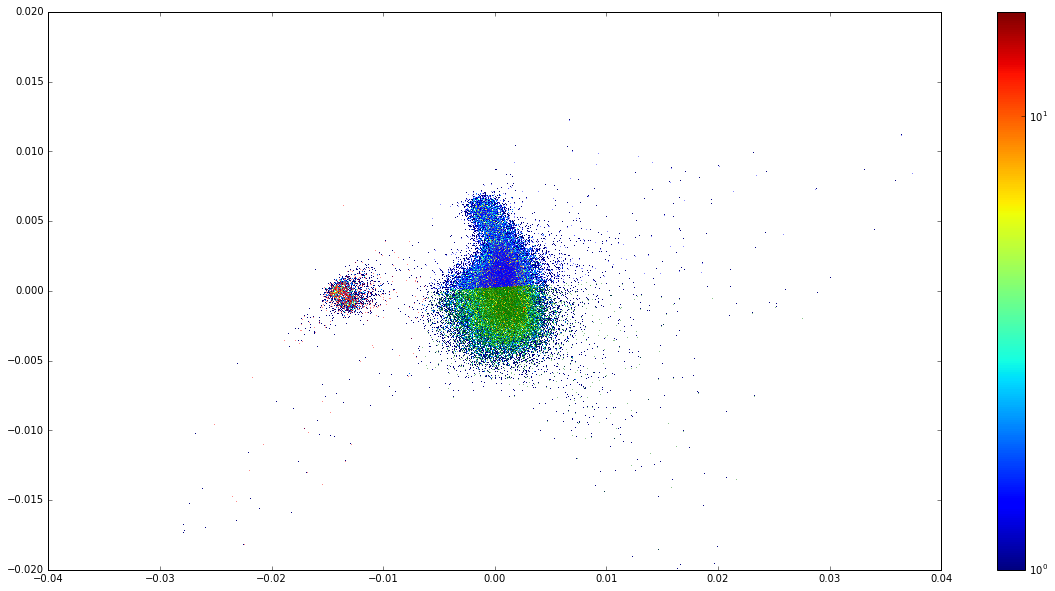

In [132]:
#Lets plot the points that we fit over
fig = plt.figure(figsize=(20,10))
plt.hist2d(X_t[:,0], X_t[:,1], bins=(1000,1000), range=((-0.04,0.04),(-0.02, 0.02)), norm=LogNorm());
plt.plot(X_t[0:20000, 0][clust_Spec.labels_==0], X_t[0:20000, 1][clust_Spec.labels_==0], 
         'r.', markersize=1, alpha=0.5)
plt.plot(X_t[0:20000, 0][clust_Spec.labels_==1], X_t[0:20000, 1][clust_Spec.labels_==1], 
         'g.', markersize=1, alpha=0.5)
plt.plot(X_t[0:20000, 0][clust_Spec.labels_==2], X_t[0:20000, 1][clust_Spec.labels_==2], 
         'b.', markersize=1, alpha=0.5)
plt.xlim(-0.04, 0.04)
plt.ylim(-0.02, 0.02)
plt.colorbar()

In [107]:
print("Relative agreement between 2 PCA dims Spec and KMeans classifiers: {0:.2f}%".format(
    100*sum(clust_Spec.labels_==clust_KM.labels_[0:20000])/len(clust_KM.labels_[0:20000])))

Relative agreement between 2 PCA dims Spec and KMeans classifiers: 0.17%


In [108]:
clust_Spec.labels_[0:10]

array([2, 1, 0, 1, 2, 2, 2, 1, 1, 2], dtype=int32)

In [109]:
clust_KM.labels_[0:10]

array([0, 2, 1, 2, 0, 0, 0, 2, 2, 0], dtype=int32)

Need to rotate the labels to compare with KMeans:

In [130]:
def rotatelabels(labels):
    return np.array([2 if not val else val-1 for val in labels])

In [131]:
speclabels_rotated = rotatelabels(rotatelabels(clust_Spec.labels_))
print("Relative agreement between 2 PCA dims Spec and KMeans classifiers: {0:.2f}%".format(
    100*sum(speclabels_rotated==clust_KM.labels_[0:20000])/len(clust_KM.labels_[0:20000])))

Relative agreement between 2 PCA dims Spec and KMeans classifiers: 97.37%


Well, that's not entirely surprising; the spectral clustering algorithm is just the KMeans algorithm performed in some affine space (a subspace that's meant to enhance the clustering).

Let's try another? DBSCAN looks promising; it allows setting a characteristic length scale.

In [145]:
#Let's make a semi-educated guess (by looking at the 2d histogram):
#length scale = 0.001, and min_samples = 100
clust_DBSCAN = DBSCAN(eps=0.001, min_samples=2000, n_jobs=-2).fit(X_t[:, 0:2])

In [146]:
np.unique(clust_DBSCAN.labels_)

array([-1,  0])

(-0.02, 0.02)

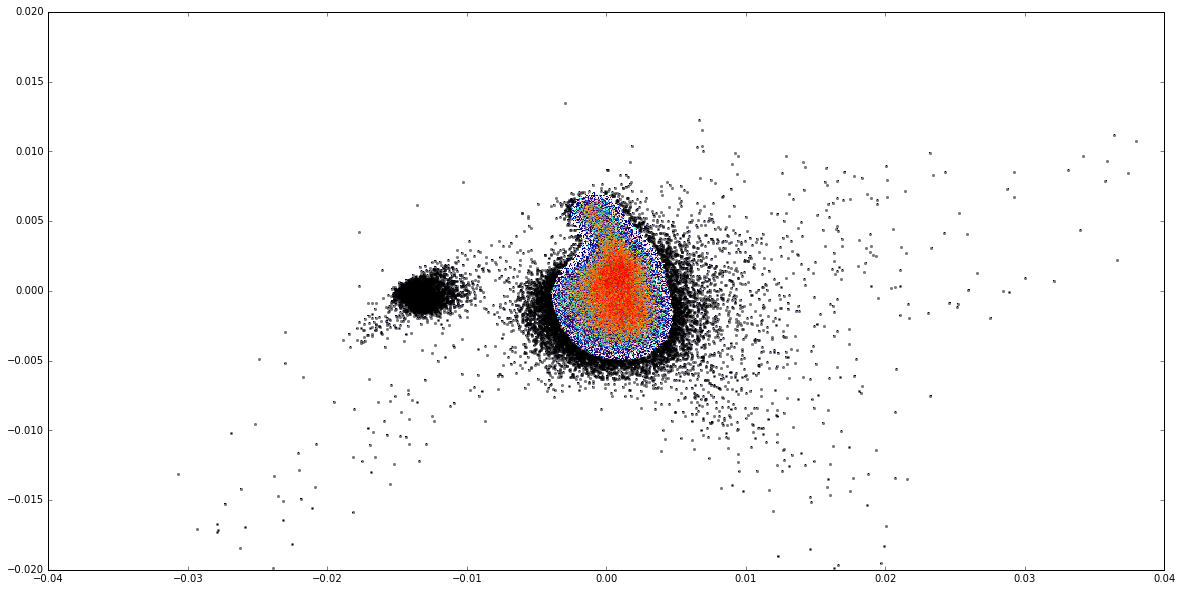

In [147]:
#Lets plot the points that we fit over
fig = plt.figure(figsize=(20,10))
plt.hist2d(X_t[:,0], X_t[:,1], bins=(1000,1000), range=((-0.04,0.04),(-0.02, 0.02)), norm=LogNorm());
plt.plot(X_t[clust_DBSCAN.labels_==0,0], X_t[clust_DBSCAN.labels_==0,1], 'r.', markersize=0.2, alpha=0.5)
plt.plot(X_t[clust_DBSCAN.labels_==1,0], X_t[clust_DBSCAN.labels_==1,1], 'g.', markersize=0.2, alpha=0.5)
plt.plot(X_t[clust_DBSCAN.labels_==-1,0], X_t[clust_DBSCAN.labels_==-1,1], 'k.', markersize=5, alpha=0.5)
plt.xlim(-0.04, 0.04)
plt.ylim(-0.02, 0.02)

Well, that looks pretty impossible to get a decent clustering with DBSCAN (I can separate neutrons and gammas well, and I like the idea that it allows for noise - unclassifiable data).

Last clustering algorithm:

In [172]:
clust_birch = Birch(threshold=0.001, branching_factor=1000,n_clusters=3).fit(X_t[:, 0:2])

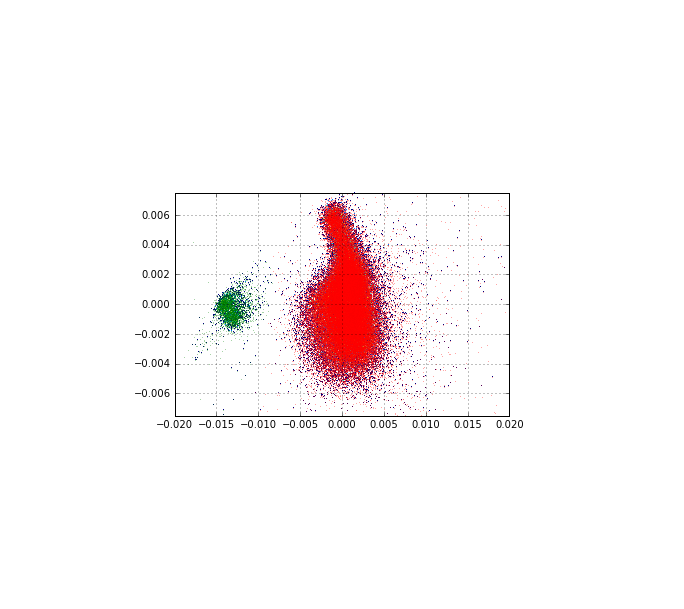

In [181]:
#Lets plot the points that we fit over
fig = plt.figure()
plt.hist2d(X_t[:,0], X_t[:,1], bins=(1000,1000), range=((-0.04,0.04),(-0.02, 0.02)), norm=LogNorm());
plt.plot(X_t[clust_birch.labels_==0,0], X_t[clust_birch.labels_==0,1], 'r.', markersize=0.5, alpha=0.8)
plt.plot(X_t[clust_birch.labels_==1,0], X_t[clust_birch.labels_==1,1], 'g.', markersize=0.5, alpha=0.8)
plt.plot(X_t[clust_birch.labels_==2,0], X_t[clust_birch.labels_==2,1], 'g.', markersize=0.5, alpha=0.8)
plt.xlim(-0.02, 0.02)
plt.ylim(-0.0075, 0.0075)
plt.grid();

OK, there's no easy way to get that to pick out the top blob either.

I think I'll need to be more tricky (maybe use DBSCAN to pick out some exemplars, then use a mean-shift?). Either way this is a waste of time without learning more about how to do clustering properly.

Let's see what we can learn by manually making cuts on the first 2 PCA dimensions.

- Neutrons = PCA[0]<-0.0085
- Gamma1 = PCA[0]>-0.0085 & PCA[1]<0.004
- Gamma2 = PCA[0]>-0.0085 & PCA[1]>0.004

In [16]:
NeutMask = X_t[:, 0] < -0.0085
Gamma1Mask = (X_t[:, 0] > -0.0085)&(X_t[:, 1]<0.004)
Gamma2Mask = (X_t[:, 0] > -0.0085)&(X_t[:, 1]>0.004)

In [208]:
h5file = tables.open_file(datafile, 'r')
Qf_abs = np.empty(len(h5file.root.wfms), dtype=np.float32)
Qt_abs = np.empty(len(h5file.root.wfms), dtype=np.float32)
lnMT = np.empty(len(h5file.root.wfms), dtype=np.float32)

for i, wfm in enumerate(h5file.root.wfms[:,0,:]):
    wfm = medfilt(wfm, kernel_size=7)
    wfm = wiener(wfm)
    BG = np.mean(wfm[10:30])
    Qt_abs[i] = sum(wfm[40:]) - (1024-40)*BG
    Qf_abs[i] = sum(wfm[40:150])-(150-40)*BG
    lnMT[i] = np.log(np.sum((wfm[40:] - BG)*np.linspace(40,1023,1023-39))/sum(wfm[40:] - BG))

h5file.close()

/home/lbignell/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/lbignell/anaconda3/lib/python3.5/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/lbignell/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


In [68]:
print(sum(nanmaskMT), sum(nanmaskMT)/len(nanmaskMT))

222881 0.995386621649


In [67]:
max(- Qt_abs)

267469.91

(4, 10)

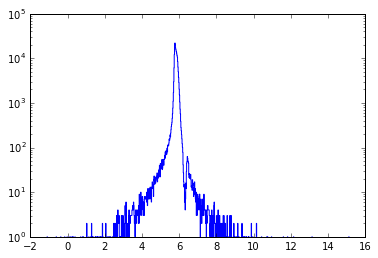

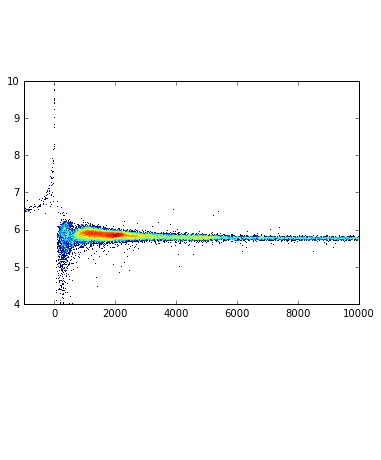

In [70]:
fig = plt.figure()
nanmaskMT = ~np.isnan(lnMT)
plt.hist(lnMT[nanmaskMT], bins=1000, histtype='step')
plt.yscale('log')
fig = plt.figure()
plt.hist2d(- Qt_abs[nanmaskMT], lnMT[nanmaskMT], bins=(1000, 1000), range=((-1000,10000),(0,12)), norm=LogNorm());
plt.ylim(4,10)

In [101]:
fig = plt.figure()
#plt.hist2d(-Qt_abs[(goodwfm)], (Qf_abs/Qt_abs)[(goodwfm)], bins=(200,200));
plt.plot(-Qt_abs[(goodwfm)][(NeutMask)], 
         (Qf_abs/Qt_abs)[(goodwfm)][(NeutMask)], 'g.', markersize=1, alpha=0.5)
plt.plot(-Qt_abs[(goodwfm)][(Gamma1Mask)], 
         (Qf_abs/Qt_abs)[(goodwfm)][(Gamma1Mask)], 'r.', markersize=1, alpha=0.5)
plt.plot(-Qt_abs[(goodwfm)][(Gamma2Mask)], 
         (Qf_abs/Qt_abs)[(goodwfm)][(Gamma2Mask)], 'b.', markersize=1, alpha=0.5)
plt.xlim(0, 100000)
plt.ylim(0.1,0.4)

/home/lbignell/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 81671
  This is separate from the ipykernel package so we can avoid doing imports until


IndexError: index 2 is out of bounds for axis 1 with size 0

Now let's see what we get when we apply the PCA transformation to the entire dataset:

In [199]:
X_t_all = thepca.transform(CLYCwfms)

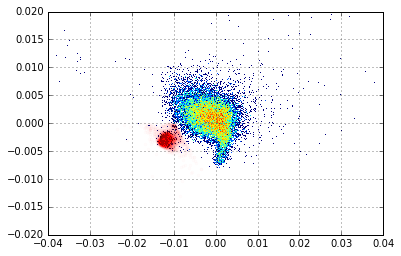

In [206]:
#Lets plot this now
fig = plt.figure()
plt.hist2d(X_t_all[:,0], X_t_all[:,1], bins=(1000,1000), norm=LogNorm(), range=((-0.04,0.04),(-0.02, 0.02)))
#plt.xlim(-0.02, 0.02)
#plt.ylim(-0.0075, 0.0075)
bottomcut = (X_t_all[:,1] < (X_t_all[:,0]*slope + intercept))&(X_t_all[:,1]<0)
plt.plot(X_t_all[:,0][bottomcut], X_t_all[:,1][bottomcut], 'r.', alpha=0.01)
plt.grid();

(0.1, 0.4)

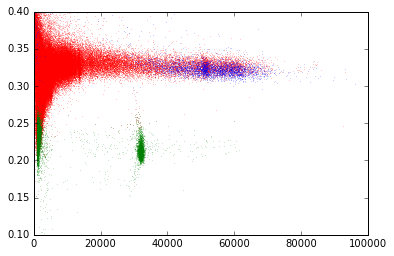

In [100]:
NeutMask_all = X_t_all[:, 0] < -0.0085
Gamma1Mask_all = (X_t_all[:, 0] > -0.01)&(X_t_all[:, 1]<0.005)
Gamma2Mask_all = (X_t_all[:, 0] > -0.01)&(X_t_all[:, 1]>0.005)
plt.plot(-Qt_abs[(Gamma1Mask_all)], 
         (Qf_abs/Qt_abs)[(Gamma1Mask_all)], 'r.', markersize=1, alpha=0.2)
plt.plot(-Qt_abs[(Gamma2Mask_all)], 
         (Qf_abs/Qt_abs)[(Gamma2Mask_all)], 'b.', markersize=1, alpha=0.2)
plt.plot(-Qt_abs[(NeutMask_all)], 
         (Qf_abs/Qt_abs)[(NeutMask_all)], 'g.', markersize=1, alpha=0.2)
plt.xlim(0, 100000)
plt.ylim(0.1,0.4)

In [211]:
X_t_all.shape

(223914, 10)

(0.1, 0.4)

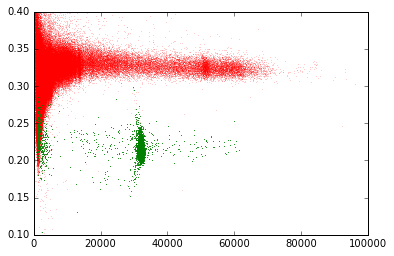

In [212]:
#NeutMask_all = X_t_all[:, 0] < -0.0085
#Gamma1Mask_all = (X_t_all[:, 0] > -0.01)&(X_t_all[:, 1]<0.005)
#Gamma2Mask_all = (X_t_all[:, 0] > -0.01)&(X_t_all[:, 1]>0.005)
#NeutCut = (X_t[:,1] < -0.005)&(X_t[:,0] > 0)
NeutCut = (X_t_all[:,1] < (X_t_all[:,0]*slope + intercept))&(X_t_all[:,1]<0)
plt.plot(- Qt_test[(~NeutCut)], 
         (Qf_abs/Qt_abs)[(~NeutCut)], 'r.',markersize=1, alpha=0.2)
plt.plot(-Qt_abs[(NeutCut)], 
         (Qf_abs/Qt_abs)[(NeutCut)], 'g.', markersize=1)#, alpha=0.2)
plt.xlim(0, 100000)
plt.ylim(0.1,0.4)

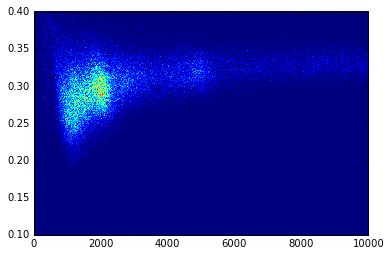

In [22]:
fig = plt.figure()
plt.hist2d(-Qt_abs, (Qf_abs/Qt_abs), bins=(500,500), range=((0,10000),(0.1,0.4)));
#plt.ylim(0.1,0.4);
#plt.xlim(0,10000);

OK, a few points:

- A multidimensional cut will almost certainly do better once you add in the noise-like parts.
- There doesn't appear to be much of a Cl-reaction-like distribution for this dataset: maybe I should choose another!

Fraction of neutrons = 0.014429690098805167
PSD FOM (Qf/Qt): 3.9320497512817383 +/- 0.029640255838512177


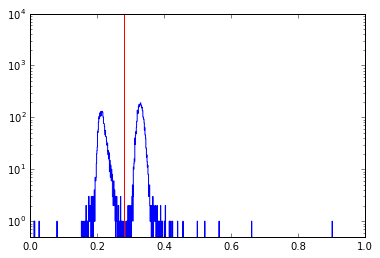

In [213]:
fig = plt.figure()
plt.hist((Qf_abs/Qt_abs)[(-Qt_abs<40000)&(25000<-Qt_abs)&((Qf_abs/Qt_abs)<=1)], bins=1000, histtype='step');
plt.yscale('log')
plt.ylim(0.5,10000)
#plt.xlim(0.2,0.3)
neutcut=0.28
plt.plot([neutcut,neutcut], [0.1, 10000], 'r')
print("Fraction of neutrons = {0}".format(len((Qf_abs/Qt_abs)[(-Qt_abs<40000)&(25000<-Qt_abs)&((Qf_abs/Qt_abs)<=neutcut)])/
                                                      len((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)<=1)])))
#Calculate estimate of PSD-FOM
mean_n = np.mean((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)<=neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)])
std_n = np.std((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)<=neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)])
umean_n = std_n/np.sqrt(len((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)]))
ustd_n = std_n/np.sqrt(2*len((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)])-2)
mean_g = np.mean((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)])
std_g = np.std((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)])
umean_g = std_g/np.sqrt(len((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)]))
ustd_g = std_g/np.sqrt(2*len((Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&(-Qt_abs<40000)&(25000<-Qt_abs)])-2)
thefom = np.abs(mean_n-mean_g)/(std_n+std_g)
theufom = np.sqrt(((mean_n/(std_n+std_g))*umean_g)**2 +
                  ((mean_g/(std_n+std_g))*umean_n)**2 +
                  ((thefom/(std_n+std_g))*ustd_g)**2 + 
                  ((thefom/(std_n+std_g))*ustd_n)**2)
print("PSD FOM (Qf/Qt): {0} +/- {1}".format(thefom, theufom))

Fraction of neutrons: 0.17690720544494762
PSD FOM (PCA): 4.378478529723395 +/- 0.03888953217422738


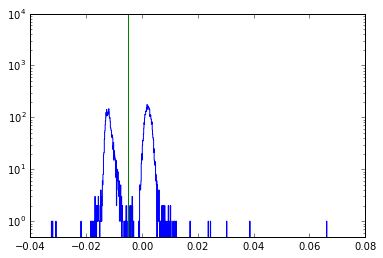

In [214]:
fig = plt.figure()
plt.hist(X_t_all[(-Qt_abs<40000)&(25000<-Qt_abs),0], bins=1000, histtype='step')
plt.yscale('log')
plt.ylim(0.5,10000)
#plt.xlim(-0.01,-0.007)
pca_neutcut=-0.005
plt.plot([pca_neutcut, pca_neutcut], [0.1, 10000])
pcaneuts = (X_t_all[:,0]<pca_neutcut)
print("Fraction of neutrons: {0}".format(len(X_t_all[pcaneuts,0])/len(X_t_all[:,0])))
#Calculate estimate of PSD-FOM
mean_n = np.mean(X_t_all[pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0])
std_n = np.std(X_t_all[pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0])
umean_n = std_n/np.sqrt(len(X_t_all[pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0]))
ustd_n = std_n/np.sqrt(2*len(X_t_all[pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0])-2)
mean_g = np.mean(X_t_all[~pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0])
std_g = np.std(X_t_all[~pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0])
umean_g = std_g/np.sqrt(len(X_t_all[pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0]))
ustd_g = std_g/np.sqrt(2*len(X_t_all[pcaneuts&(-Qt_abs<40000)&(25000<-Qt_abs), 0])-2)
thefom = np.abs(mean_n-mean_g)/(std_n+std_g)
theufom = np.sqrt(((mean_n/(std_n+std_g))*umean_g)**2 +
                  ((mean_g/(std_n+std_g))*umean_n)**2 +
                  ((thefom/(std_n+std_g))*ustd_g)**2 + 
                  ((thefom/(std_n+std_g))*ustd_n)**2)
print("PSD FOM (PCA): {0} +/- {1}".format(thefom,theufom))
                                    

In [215]:
4.41/3.93

1.1221374045801527

THIS LOOKS PRETTY GOOD: DOCUMENT THIS! (SAVE PLOTS AND WRITE UP NOTE).

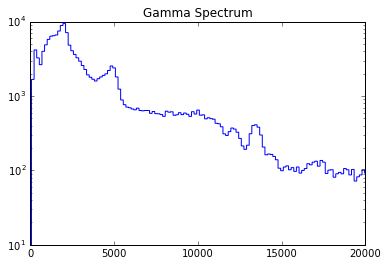

In [319]:
fig = plt.figure()
plt.hist((-Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&((Qf_abs/Qt_abs)<=1)], bins=1000, histtype='step');
plt.yscale('log')
plt.xlim(0,20000)
plt.title('Gamma Spectrum')

# Significance of FOM increase:

This is pretty easy to work out. The FOM (as I've defined it, not the usual one) is the logical place for a cut - it is average number of standard deviations the two distributions are separated by. It can pretty easily be shown that (for the simplified case that the gamma and neutron distributions are Gaussian) the misclassification probability is equal to:

$1 - \text{CDF}( \mu_{1} + \text{FOM}\sigma_{1} ) = 1 - 0.5\left[ 1 + \text{erf}\left( \frac{\mu_{1} + \text{FOM}\sigma_{1} - \mu_{1}}{\sigma_{1}\sqrt{2}} \right)\right] = 1 - 0.5\left[ 1 + \text{erf}\left( \frac{\text{FOM}}{\sqrt{2}} \right)\right]$

(Note that the false positive/misclassification probability is symmetric in this case due to the symmetry of the Gaussian function).
I've compared the charge comparison method to PCA-PSD in two ways so far:

- All events that passed the charge cut which was used to train the PCA.
- Only events that fell within a rough thermal neutron charge window.

Let's look at how the FOM increase has improved the gamma misclassification probability:

In [88]:
FOM_CCM_chargecut = 2.7724357269906608
FOM_PCA_chargecut = 3.4075496972584096
FOM_CCM_thermcut = 3.9320497512817383
FOM_PCA_thermcut = 4.416571627844179
p_falsepos_CCM_chargecut = 1 - 0.5*(1+np.math.erf(FOM_CCM_chargecut/np.sqrt(2)))
p_falsepos_CCM_thermcut = 1 - 0.5*(1+np.math.erf(FOM_CCM_thermcut/np.sqrt(2)))
p_falsepos_PCA_chargecut = 1 - 0.5*(1+np.math.erf(FOM_PCA_chargecut/np.sqrt(2)))
p_falsepos_PCA_thermcut = 1 - 0.5*(1+np.math.erf(FOM_PCA_thermcut/np.sqrt(2)))
print('Misclassification Probabilities')
print('CCM, charge cut: {0}'.format(p_falsepos_CCM_chargecut))
print('PCA, charge cut: {0}'.format(p_falsepos_PCA_chargecut))
print('CCM/PCA false positives: {0}'.format(p_falsepos_CCM_chargecut/p_falsepos_PCA_chargecut))
print('CCM, thermal cut: {0}'.format(p_falsepos_CCM_thermcut))
print('PCA, thermal cut: {0}'.format(p_falsepos_PCA_thermcut))
print('CCM/PCA false positives: {0}'.format(p_falsepos_CCM_thermcut/p_falsepos_PCA_thermcut))

Misclassification Probabilities
CCM, charge cut: 0.0027819252830878494
PCA, charge cut: 0.0003277448533038907
CCM/PCA false positives: 8.488082284265193
CCM, thermal cut: 4.2112314410758245e-05
PCA, thermal cut: 5.013934069264536e-06
CCM/PCA false positives: 8.399056275770983


Good, now let's make a plot of FOM vs charge for both.

In [83]:
Qt_srt = sorted(-Qt_abs)
nbins = 20
cutedges = np.empty(nbins+1, dtype=np.int)
cutedges[0] = min(Qt_srt)
for i in range(nbins):
    cutedges[i+1] = Qt_srt[(i+1)*int(len(Qt_srt)/nbins)]

In [89]:
cutedges

array([ -1929,    493,    887,   1062,   1205,   1345,   1497,   1657,
         1819,   1961,   2104,   2303,   2653,   3183,   4094,   4928,
         6686,   9669,  14285,  32218, 128196])

In [90]:
FOM_CCM = np.empty(nbins, dtype=np.float64)
UFOM_CCM = np.empty(nbins, dtype=np.float64)
FOM_PCA = np.empty(nbins, dtype=np.float64)
UFOM_PCA = np.empty(nbins, dtype=np.float64)
neutcut=0.28 #for CCM
pca_neutcut=-0.005
pcaneuts = (X_t_all[:,0]<pca_neutcut)

for i in range(nbins):
    #Calculate estimate of PSD-FOM
    #thisslice = (Qf_abs/Qt_abs)[i*int(len(Qf_abs)/nbins):(i+1)*int(len(Qf_abs)/nbins)]
    #thisqabs = Qt_abs[i*int(len(Qf_abs)/nbins):(i+1)*int(len(Qf_abs)/nbins)]
    theneuts = (Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)<=neutcut)&(cutedges[i]<-Qt_abs)&(-Qt_abs<cutedges[i+1])]
    mean_n = np.mean(theneuts)
    std_n = np.std(theneuts)
    umean_n = std_n/np.sqrt(len(theneuts))
    ustd_n = std_n/np.sqrt(2*len(theneuts)-2)
    thegammas = (Qf_abs/Qt_abs)[((Qf_abs/Qt_abs)>neutcut)&(cutedges[i]<-Qt_abs)&(-Qt_abs<cutedges[i+1])]
    mean_g = np.mean(thegammas)
    std_g = np.std(thegammas)
    umean_g = std_g/np.sqrt(len(thegammas))
    ustd_g = std_g/np.sqrt(2*len(thegammas)-2)
    FOM_CCM[i] = np.abs(mean_n-mean_g)/(std_n+std_g)
    UFOM_CCM[i] = np.sqrt(((mean_n/(std_n+std_g))*umean_g)**2 +
                          ((mean_g/(std_n+std_g))*umean_n)**2 +
                          ((FOM_CCM[i]/(std_n+std_g))*ustd_g)**2 + 
                          ((FOM_CCM[i]/(std_n+std_g))*ustd_n)**2)
    #print("CCM FOM: {0}".format(np.abs(mean_n-mean_g)/(std_n+std_g)))
    #Calculate estimate of PSD-FOM
    thisxt = (X_t_all)[i*int(len(Qf_abs)/nbins):(i+1)*int(len(Qf_abs)/nbins)]
    thispcaneuts = pcaneuts[i*int(len(Qf_abs)/nbins):(i+1)*int(len(Qf_abs)/nbins)]
    mean_n = np.mean(X_t_all[pcaneuts&(cutedges[i]<-Qt_abs)&(-Qt_abs<cutedges[i+1]), 0])
    std_n = np.std(X_t_all[pcaneuts&(cutedges[i]<-Qt_abs)&(-Qt_abs<cutedges[i+1]), 0])
    umean_n = std_n/np.sqrt(len(theneuts))
    ustd_n = std_n/np.sqrt(2*len(theneuts)-2)
    mean_g = np.mean(X_t_all[~pcaneuts&(cutedges[i]<-Qt_abs)&(-Qt_abs<cutedges[i+1]), 0])
    std_g = np.std(X_t_all[~pcaneuts&(cutedges[i]<-Qt_abs)&(-Qt_abs<cutedges[i+1]), 0])
    umean_g = std_g/np.sqrt(len(thegammas))
    ustd_g = std_g/np.sqrt(2*len(thegammas)-2)
    #print("PSD FOM: {0}".format(np.abs(mean_n-mean_g)/(std_n+std_g)))
    FOM_PCA[i] = np.abs(mean_n-mean_g)/(std_n+std_g)
    UFOM_PCA[i] = np.sqrt(((mean_n/(std_n+std_g))*umean_g)**2 +
                          ((mean_g/(std_n+std_g))*umean_n)**2 +
                          ((FOM_PCA[i]/(std_n+std_g))*ustd_g)**2 + 
                          ((FOM_PCA[i]/(std_n+std_g))*ustd_n)**2)


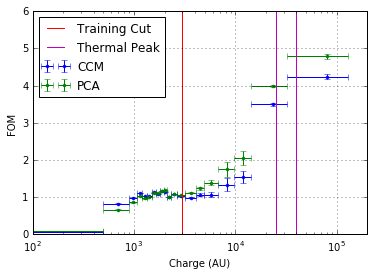

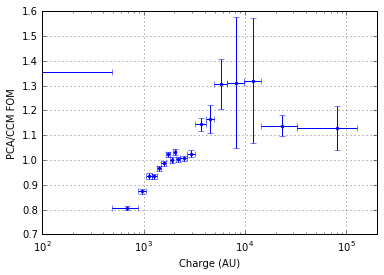

In [216]:
cutcentres = np.empty(nbins, dtype=np.float64)
xbars = np.empty(nbins, dtype=np.float64)
for i in range(nbins):
    cutcentres[i] = np.mean((cutedges[i], cutedges[i+1]))
    xbars[i] = (cutedges[i+1]-cutedges[i])/2
plt.errorbar(cutcentres, FOM_CCM, yerr=UFOM_CCM, xerr=xbars, fmt='.', label='CCM')
plt.errorbar(cutcentres, FOM_PCA, yerr=UFOM_PCA, xerr=xbars, fmt='.', label='PCA')
plt.plot([3000,3000], [0,10], 'r', label='Training Cut')
plt.plot([25000,25000], [0,10], '-m', label='Thermal Peak')
plt.plot([40000,40000], [0,10], '-m')
plt.ylim(0,6)
plt.xlim(100,200000)
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Charge (AU)')
plt.ylabel('FOM')
plt.grid()

plt.figure()
UFOM_combined = np.sqrt(UFOM_CCM**2 + UFOM_PCA**2)
plt.errorbar(cutcentres, FOM_PCA/FOM_CCM, xerr=xbars, yerr=UFOM_combined, fmt='.')
plt.grid()
plt.xscale('log')
plt.xlim(100,200000)
plt.xlabel('Charge (AU)')
plt.ylabel('PCA/CCM FOM')

So the PCA performs better for all charges greater than where we set the training cut, but it doesn't perform well below the training cut: i.e. the model doesn't generalise to data that are below the training cut. I find this a little surprising, given that we normalise to charge before applying the PCA transform.

Now, for completion, let's work out the false positive probabilities:

In [92]:
sum(thepca.explained_variance_ratio_[0:3])

0.51396782093669213

4.2407308734533569

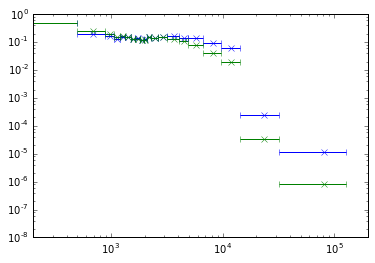

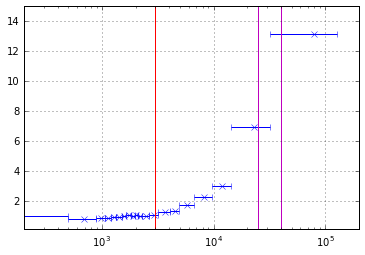

In [93]:
falsepos_CCM = np.empty(nbins, dtype=np.float64)
falsepos_PCA = np.empty(nbins, dtype=np.float64)
for i in range(nbins):
    falsepos_CCM[i] = 1 - 0.5*(1+np.math.erf(FOM_CCM[i]/np.sqrt(2)))
    falsepos_PCA[i] = 1 - 0.5*(1+np.math.erf(FOM_PCA[i]/np.sqrt(2)))
    
plt.errorbar(cutcentres, falsepos_CCM, xerr=xbars, fmt='x', label='Charge Comparison')
plt.errorbar(cutcentres, falsepos_PCA, xerr=xbars, fmt='x', label='PCA')
plt.xlim(200,200000)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.00000001,1)

plt.figure()
plt.errorbar(cutcentres, falsepos_CCM/falsepos_PCA, xerr=xbars, fmt='x', label='CCM/PCA')
plt.plot([3000,3000], [0,20], 'r', label='Training Cut')
plt.plot([25000,25000], [0,20], '-m', label='Thermal Peak')
plt.plot([40000,40000], [0,20], '-m')

plt.xlim(200,200000)
plt.xscale('log')
plt.ylim(0.1,15)
plt.grid()

np.mean((falsepos_CCM/falsepos_PCA)[-7:])